# Capstone end of week 9 progress

Having collected the data and performed the EDA, it is time to move on to the initial model fitting. However before fitting any models, it would be necessary to refine the data into a format that the modling module can take as input. It would also be great if some further plotting demonstrating the relationships between features. First the required moduels are loaded into the Notebook.

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
engine = create_engine('postgresql://localhost/capstone')
lego = pd.read_sql('SELECT * FROM lego_cleaned_temp', engine)
lego.head()

,Item_Number,Name,Year,Theme,Subtheme,Pieces,Minifigures,Image_URL,USD_MSRP,Packaging,Availability,wanted,owned,rating,theme_grp,review_num,query_id,adjust_coef,adj_USD_MSRP
0,10246,Detective's Office,2015,Advanced Models,Modular Buildings,2262.0,6.0,http://images.brickset.com/sets/images/10246-1...,159.99,Box,Retail - limited,5008.0,10155.0,4.75,Model making,4,10246-1,1.0,159.99
1,10247,Ferris Wheel,2015,Advanced Models,Fairground,2464.0,10.0,http://images.brickset.com/sets/images/10247-1...,199.99,Box,Retail - limited,3219.0,4807.0,5,Model making,3,10247-1,1.0,199.99
2,10248,Ferrari F40,2015,Advanced Models,Vehicles,1158.0,0.0,http://images.brickset.com/sets/images/10248-1...,99.99,Box,LEGO exclusive,2030.0,3943.0,5,Model making,4,10248-1,1.0,99.99
3,10249,Toy Shop,2015,Advanced Models,Winter Village,898.0,0.0,http://images.brickset.com/sets/images/10249-1...,79.99,Box,LEGO exclusive,2046.0,4794.0,4,Model making,1,10249-1,1.0,79.99
4,10581,Ducks,2015,Duplo,Forest Animals,13.0,1.0,http://images.brickset.com/sets/images/10581-1...,9.99,Box,Retail,117.0,444.0,0,Pre-school,0,10581-1,1.0,9.99


By looking at the preview above it is decided that some features will not be used in the analysis. They are:

- Item_numbers: Unique to each set
- Name: unique to each set
- Image_URL: unique to each set 
- USD_MSRP: The target will be the adjusted price instead
- adj_coef: Only used to adjust inflation
- query_id: generated from Image_URL for scraping 

Therefore those rows will be dropped.

In [3]:
lego = lego.drop(['Item_Number','Name','Image_URL','USD_MSRP','query_id','adjust_coef'], axis=1)

In [4]:
lego.head(2)

,Year,Theme,Subtheme,Pieces,Minifigures,Packaging,Availability,wanted,owned,rating,theme_grp,review_num,adj_USD_MSRP
0,2015,Advanced Models,Modular Buildings,2262.0,6.0,Box,Retail - limited,5008.0,10155.0,4.75,Model making,4,159.99
1,2015,Advanced Models,Fairground,2464.0,10.0,Box,Retail - limited,3219.0,4807.0,5,Model making,3,199.99


We can also see that there are lots of categorical variables which are not directly comparable to each other. Therefore dummy variables will be created for such data to be used in the model

In [5]:
theme = pd.get_dummies(lego.Theme, drop_first=True)
subtheme = pd.get_dummies(lego.Subtheme, drop_first=True)
packaging = pd.get_dummies(lego.Packaging, drop_first=True)
availability = pd.get_dummies(lego.Availability, drop_first=True)
theme_grp = pd.get_dummies(lego.theme_grp, drop_first=True)
lego = lego.drop(['Theme','Subtheme','Packaging','Availability','theme_grp'],axis=1)

Having created all the necessary dummy variables and cleaned the main data grame, a final check was performed which shows that 2 of the features are 'objects'. These 2 features are rating and review_num respectively. Therefore they were converted into float type before the final combination was carried out.

In [6]:
lego.rating = lego.rating.astype(float)
lego.review_num = lego.review_num.astype(float)
lego_w_dummies = pd.concat([lego,theme,subtheme,packaging,availability,theme_grp],axis=1)
lego_w_dummies.head(2)

,Year,Pieces,Minifigures,wanted,owned,rating,review_num,adj_USD_MSRP,Action Wheelers,Advanced Models,...,Historical,Junior,Licensed,Miscellaneous,Model making,Modern day,Pre-school,Racing,Technical,Vintage themes
0,2015,2262.0,6.0,5008.0,10155.0,4.75,4.0,159.99,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2015,2464.0,10.0,3219.0,4807.0,5.00,3.0,199.99,0,1,...,0,0,0,0,1,0,0,0,0,0


In order to gain a deeper understanding in the relationship between features, a heatmap is created. The deeper the color of a square(either blue or red) the greater the realtionship there is. Red represents a positive crrelation and blue represents a negative correlation. From the plot we can see that there is a diagonal line runing thorguh the center which means variables are 100% correlated with themselves (obviously). However there are also other deep solid red squares within the map. These pairs are

- Number of pieces and adjusted price
- Number of 'wanted' votes and number of 'owned' vote
- Number of 'wanted' votes and number of pieces

These are all paris of variables that positively correlate with each other. In order to examine the actual distribution, a pairplot is generated.

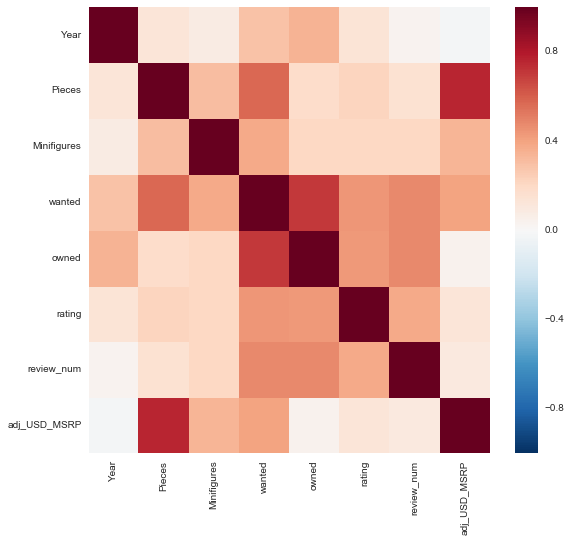

In [12]:
plt.figure(figsize=(9,8))
sns.heatmap(lego.corr())
plt.show()

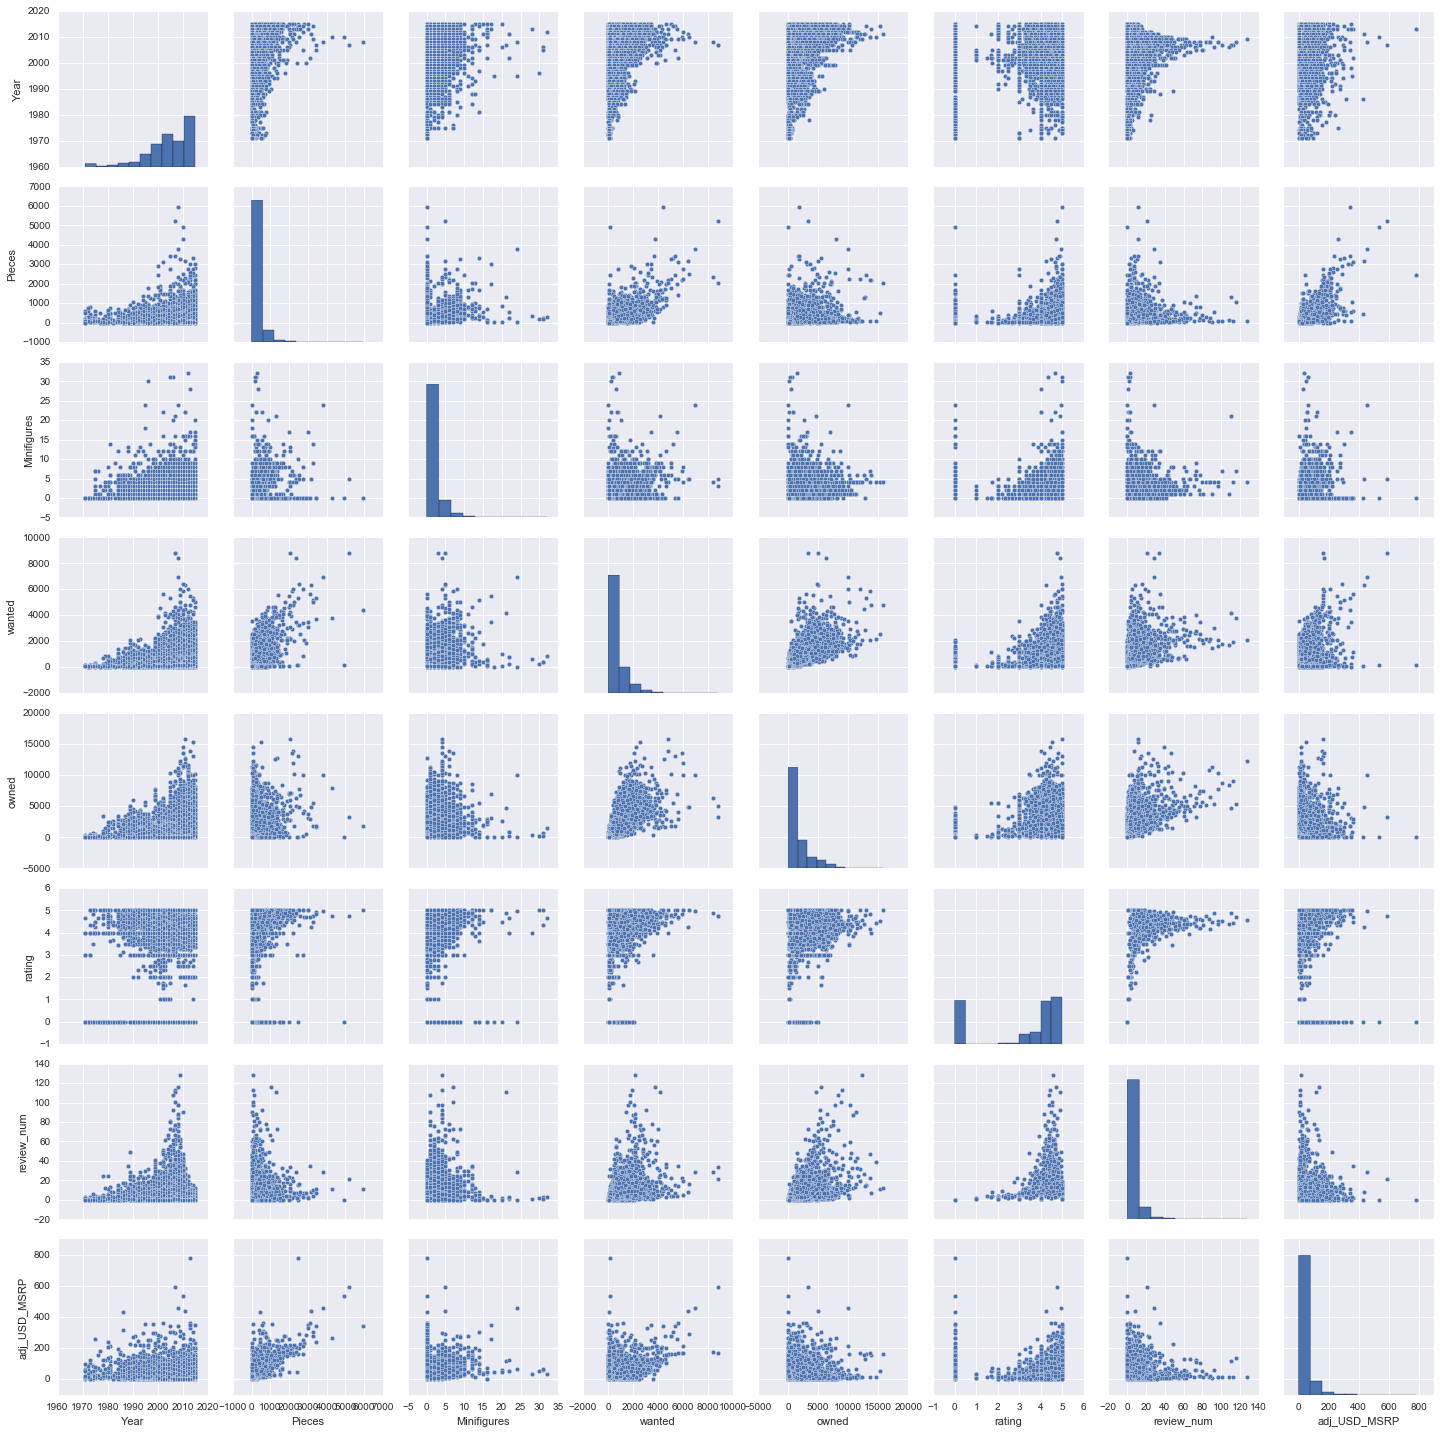

In [14]:
sns.pairplot(lego)
plt.show()

The pairplot shows various scatter plots and histograms to demonstrate relationship between features. In order to examine more on the findings that we obtained in the heat map, the relevant plots are analysed.

We can see that all the combinations with higher correlations have a shape more like a funnel. Although it seems to be quite spreaded out, we have to remeber that we have more than 6000 data points and many of them might be overlayed by others. If the overlayed ones lie very close together and forms a linear line, the correlation coefficient can still be high. 

On the other hand others plots have either an irregular shape or shaped like a cluster that grows equally from the origin.

There are other interesting insights that might or might not help in the modelling phase:


- More recent sets are more popular both in terms of 'wanted' and 'owned'
- Sets released in 2008 and 2009 seems to be reviewed the most which we can assume that they are more popular
- Lego sets get bigger and bigger through out the year and topped at around 2008 and 2009 
- However the most reviewed sets are not the largest sets. The most reviewed sets all have a number of pieces under 2000
- There are usually Minifigures in sets that get reviewed a lot
- Highly wanted sets are not necessarily expensive (vice versa)
- A minimum rating of 4 is almost guaranteed if a set has at least 60 reviews
- The number of reviews decreases as the sets get more expensive

## Initial regression analysis on Lego MSRP 

The first aim of the project is to predict Lego sets MSRP in USD. The success criteria is to get within 15% of the true price. From the EDA we can see that the price varies approximately linearly with some of the variables such as number of pieces. Therefore it would be logical to start of with models such as Linear Regressions and its regualrised counterparts. 

In [7]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Initial regression models

Define features and targets

In [8]:
X = lego_w_dummies.drop('adj_USD_MSRP', axis=1)
y = lego_w_dummies['adj_USD_MSRP']

In order to prevent overfitting, a train-test split will be carried out. This operation divides the data into a training set and a testing set. This allows us to fit the model with the train data and test it with the unseen test data. Typically the train data would include the majority of instances in the data set to allow good model fit. In this case, it is decided that a 4:1 train-test split to be used.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [10]:
reg = LinearRegression()
model = reg.fit(X_train,y_train)
pred = model.predict(X_test)

Having fitted the model and made a prediction, it is time to check the various metrics. There are three metrics that are commonly used in regression analysis namely mean squared error (MSE), mean absolute error (MAE) and R squared score (r2 score). 

In [11]:
print 'MSE: ',mean_squared_error(y_test,pred)
print 'MAE: ',mean_absolute_error(y_test,pred)
print 'R2: ', r2_score(y_test,pred)

MSE:  9.42593150268e+13
MAE:  493232.246384
R2:  -41071851314.1


In order to better visualise the model, the predicted price is plotted agains the actual price. In an ideal situation we sould observe a closely pcaked cluster which demonstrates a trend that represents that actual price equals to predicted price

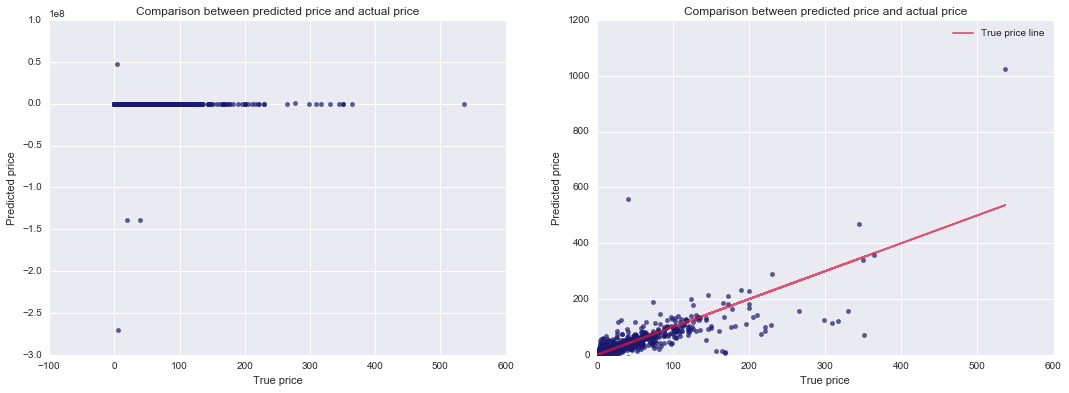

In [12]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(y_test, pred, color='midnightblue', alpha=.7)
ax2.scatter(y_test, pred, color='midnightblue', alpha=.7)
ax1.set(xlabel='True price',ylabel='Predicted price',title='Comparison between predicted price and actual price')
ax2.set(xlabel='True price',ylabel='Predicted price',title='Comparison between predicted price and actual price',xlim=[0,600],ylim=[0,1200])
ax2.plot(y_test,y_test,color='crimson',alpha=.7,label='True price line')
plt.legend()
plt.show()

The plot on the left above is definetly not something that represents a good regression model. It can be observed that y axis has a scale of 1e7 which represents 10million. Therefore from the analysis we can see that a model is predicting a 40million price for one Lego set. This is not a reasonable price for any Lego set. There are other unreasonable outliers such as negative values too.

However interestingly when we zoom in to limit true prices between 0-600 and predicted prices between 0-1200 (as shown in the right hand side plot), it can be seen that this regression is actually doing a fair job within this section. This can be shown with the 'True price line' which demonstrates what the plot would be like if the predictions were 100% accurate. We can see that in general the points in the graph lie relatively closely to the line.

From the above information, it would be reasonable to assume that a linear model can perform well in this problem. However due to certain factors it can produce strange results for some cases. Overfitting would be a major contributor in this instability. 

In this model, there are 509 input features where all but 8 of them are categorical dummy variables. Intuitively it is reasonable to assume that not all the features are equally informative. On the other hand some features could be highly correlated. Either of those would affect the performance of the regression model.

Therefore in order to try mitigating the effect of the described phenomenon, a Lasso regression and Ridge regression is performed as further investigations.

MSE:  819.748098286
MAE:  14.6379565251
R2:  0.642809074105
10 fold CV average R2:  0.624208301397
10 fold CV R2 standard deviation:  0.0584434896999
10 fold CV average MAE:  -14.7842073738
10 fold CV MAE standard deviation:  4.73271002123
10 fold CV average MSE:  -787.68913721
10 fold CV MSE standard deviation:  380.255884895


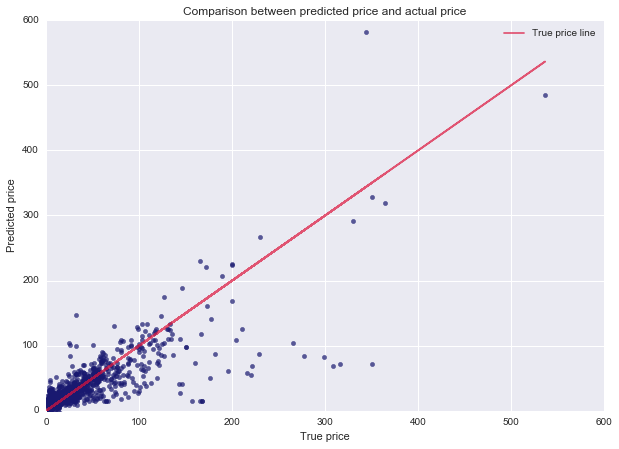

In [10]:
reg = Lasso()
model = reg.fit(X_train,y_train)
pred = model.predict(X_test)
score = cross_val_score(reg,X_train,y_train,cv=10)
maescore = cross_val_score(reg,X,y,cv=10,scoring='neg_mean_absolute_error')
msescore = cross_val_score(reg,X,y,cv=10,scoring='neg_mean_squared_error')
print 'MSE: ',mean_squared_error(y_test,pred)
print 'MAE: ',mean_absolute_error(y_test,pred)
print 'R2: ', r2_score(y_test,pred)
print '10 fold CV average R2: ', np.mean(score)
print '10 fold CV R2 standard deviation: ',np.std(score)
print '10 fold CV average MAE: ', np.mean(maescore)
print '10 fold CV MAE standard deviation: ', np.std(maescore)
print '10 fold CV average MSE: ', np.mean(msescore)
print '10 fold CV MSE standard deviation: ', np.std(msescore)

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(y_test, pred, color='midnightblue', alpha=.7)
ax1.set(xlabel='True price',
        ylabel='Predicted price',
        title='Comparison between predicted price and actual price',
        xlim=[0,600],
        ylim=[0,600])
ax1.plot(y_test,y_test,color='crimson',alpha=.7,label='True price line')
plt.legend()
plt.show()

MSE:  752.204652521
MAE:  12.6903378516
R2:  0.67223995169
10 fold CV average R2:  0.705436395255
10 fold CV R2 standard deviation:  0.0529458839838
10 fold CV average MAE:  -14.2998664447
10 fold CV MAE standard deviation:  3.51500864797
10 fold CV average MSE:  -702.605433913
10 fold CV MSE standard deviation:  309.997501253


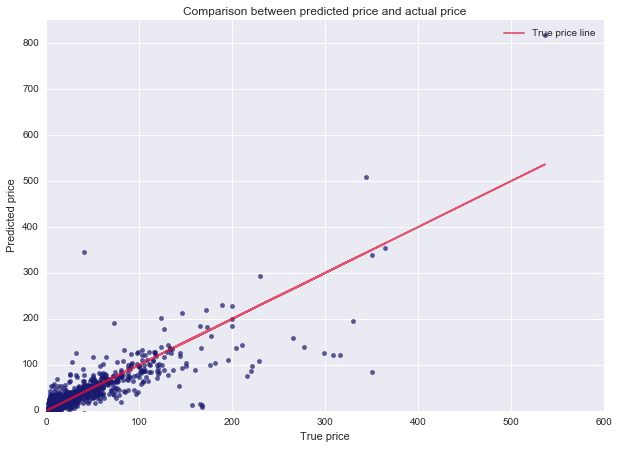

In [11]:
reg = Ridge()
model = reg.fit(X_train,y_train)
pred = model.predict(X_test)
score = cross_val_score(reg,X_train,y_train,cv=10)
maescore = cross_val_score(reg,X,y,cv=10,scoring='neg_mean_absolute_error')
msescore = cross_val_score(reg,X,y,cv=10,scoring='neg_mean_squared_error')
print 'MSE: ',mean_squared_error(y_test,pred)
print 'MAE: ',mean_absolute_error(y_test,pred)
print 'R2: ', r2_score(y_test,pred)
print '10 fold CV average R2: ', np.mean(score)
print '10 fold CV R2 standard deviation: ',np.std(score)
print '10 fold CV average MAE: ', np.mean(maescore)
print '10 fold CV MAE standard deviation: ', np.std(maescore)
print '10 fold CV average MSE: ', np.mean(msescore)
print '10 fold CV MSE standard deviation: ', np.std(msescore)
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(y_test, pred, color='midnightblue', alpha=.7)
ax1.set(xlabel='True price',
        ylabel='Predicted price',
        title='Comparison between predicted price and actual price',
        xlim=[0,600],
        ylim=[0,850])
ax1.plot(y_test,y_test,color='crimson',alpha=.7,label='True price line')
plt.legend()
plt.show()

The above plots and result figures have demonstrate clearly of how regularisations can effectively improve models performance. This is best demonstrated by the significant reduction in MSE and MAE. R2 score has increased from negative value to above 0.6 (Although the number of features has an affect on R2 scores, the comparison in this case is still valid because number of features are constant).  

The principle of regularisation techniques is to add an extra term to the cost function which is related to the size of the coefficients. This would affect the process of minimising the cost function by limiting the magnitude of coefficents. 

The strength of coefficients can be altered by changing the 'alpha' parameter. Higher alpha represents stronger regularisation. It is possible to use Grid Search method in order to obtain the best 'alpha' value. 

#### Fine tuning Lasso with Grid Search

Lasso regression is the combination of linear regression and a 'l1' regularisation. This regularisation term is proportional to the absolute values of feature coefficients. A Grid Search method is used to try obtaining the best alpha value for such regularisation. A 10 fold cross validation is used in the Grid Search process to make sure the model is stable and be able to deal with unseen data.

In [66]:
from sklearn.grid_search import GridSearchCV
params = {'alpha':np.logspace(-2,2,5)}
las = Lasso(max_iter=3000)
clf = GridSearchCV(las,params,cv=10)
model = clf.fit(X_train,y_train)
print 'Optimum alpha: ',model.best_params_
print 'Best score: ',model.best_score_
model.grid_scores_

Optimum alpha:  {'alpha': 0.01}
Best score:  0.70602847914


[mean: 0.70603, std: 0.04762, params: {'alpha': 0.01},
 mean: 0.69392, std: 0.04771, params: {'alpha': 0.10000000000000001},
 mean: 0.62419, std: 0.05844, params: {'alpha': 1.0},
 mean: 0.59242, std: 0.05906, params: {'alpha': 10.0},
 mean: 0.57790, std: 0.05753, params: {'alpha': 100.0}]

By looking at the results it can be said that the alpha value which yeidls the best result is 0.01. This means a small amount of regularisation is applied. We can also see that an alpha of 0.01 results in the least standard deviation of R2 scores in the model which suggests that it is also more stable. Using the best parameters, a new prediction for the test set is generated.

MSE:  938.678115156
MAE:  12.9571251284
R2:  0.590987395065


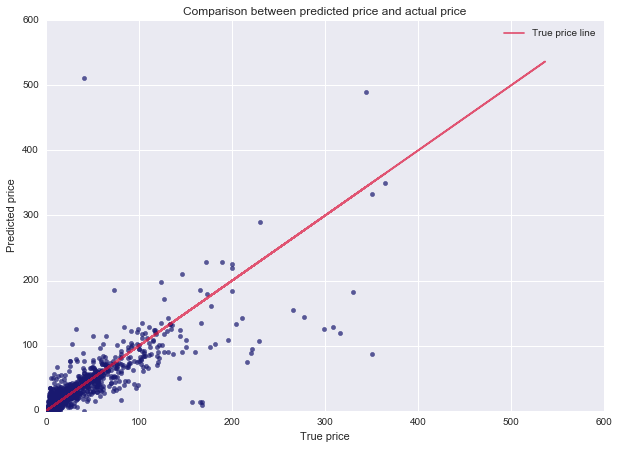

In [67]:
lasso_model = model.best_estimator_.fit(X_train,y_train)
lasso_pred = lasso_model.predict(X_test)
print 'MSE: ',mean_squared_error(y_test,lasso_pred)
print 'MAE: ',mean_absolute_error(y_test,lasso_pred)
print 'R2: ', r2_score(y_test,lasso_pred)
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(y_test, lasso_pred, color='midnightblue', alpha=.7)
ax1.set(xlabel='True price',
        ylabel='Predicted price',
        title='Comparison between predicted price and actual price',
        xlim=[0,600],
        ylim=[0,600])
ax1.plot(y_test,y_test,color='crimson',alpha=.7,label='True price line')
plt.legend()
plt.show()

From the results above we can see that the performance of the test set have dropped despite using the optimised parameter. There could be many reasons that can cause such a result. Overfitting could be one of them. In this case the cross validation is carried out with the training set which might not have the exact same data structure as the testing set. Therefore when a model is highly optimised with the training set, the variance might be so high that it does not fit well with the testing set. This idea of overfitting is further supported by the alpha value of 0.01 which means little regularisation (in other words bias) is introduced.

In [53]:
params = {'alpha':np.logspace(-2,2,5)}
rid = Ridge(max_iter=3000)
clf = GridSearchCV(rid,params,cv=10)
model = clf.fit(X_train,y_train)
print 'Optimum alpha: ',model.best_params_
print 'Best score: ',model.best_score_
model.grid_scores_

Optimum alpha:  {'alpha': 1.0}
Best score:  0.705384326707


[mean: 0.69587, std: 0.05279, params: {'alpha': 0.01},
 mean: 0.69880, std: 0.05262, params: {'alpha': 0.10000000000000001},
 mean: 0.70538, std: 0.05292, params: {'alpha': 1.0},
 mean: 0.70491, std: 0.05362, params: {'alpha': 10.0},
 mean: 0.68207, std: 0.05504, params: {'alpha': 100.0}]

MSE:  751.885133214
MAE:  12.6850309816
R2:  0.672379176651


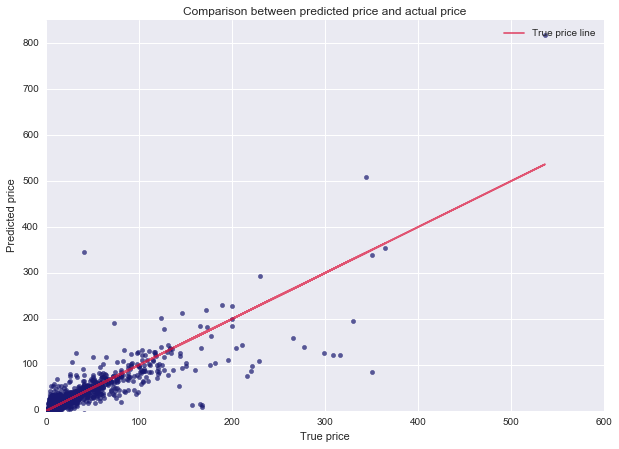

In [55]:
ridge_model = model.best_estimator_.fit(X_train,y_train)
ridge_pred = ridge_model.predict(X_test)
print 'MSE: ',mean_squared_error(y_test,ridge_pred)
print 'MAE: ',mean_absolute_error(y_test,ridge_pred)
print 'R2: ', r2_score(y_test,ridge_pred)
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(y_test, ridge_pred, color='midnightblue', alpha=.7)
ax1.set(xlabel='True price',
        ylabel='Predicted price',
        title='Comparison between predicted price and actual price',
        xlim=[0,600],
        ylim=[0,850])
ax1.plot(y_test,y_test,color='crimson',alpha=.7,label='True price line')
plt.legend()
plt.show()

### Coefficient Analysis

Having performed regression analysis with various regularisation techniques, it would be useful to look at their resultant coefficient. This can provide an insight on what factors contributes most to the MSRP of Lego sets. It is important to note that both ends of the spectrums are to be examined because those are the features that drives the prices significantly (either up or down).

In [59]:
ridge_coef = zip(X_train.columns,ridge_model.coef_)
ridge_coef = sorted(ridge_coef, key=lambda x:x[1], reverse=True)
ridge_coef[:5]

[(u'Serious Play', 210.49417266904464),
 (u'Educational', 110.61339324042073),
 (u'Outdoor RC', 79.18147788508621),
 (u'Monorail', 62.136327702971464),
 (u'Unitron', 48.223916003837758)]

In [60]:
ridge_coef[-5:]

[(u'Mindstorms', -35.728592993426894),
 (u'Education', -44.41695475797075),
 (u'Dacta', -55.463824670648393),
 (u'Mosaic', -59.917523414465052),
 (u'Buildings', -77.048054081820268)]

From the coefficients for Ridge Regression above we can see that tag 'Serious Play' plays a very important part in MSRP. Upon investigation it is found out that there are only 3 sets that has the 'Serious Play' tag and they are all highly priced. The coefficient size decreases rapidly to 48 with 'Unitron' in the 5th place. It is interesting to see that the most significant coefficients are binary types rather than the numerical type features such as pieces. It can be seen that 'Buildings' are the most negatively correlated feature. However its magnitude is much smaller at 77.  

In [61]:
lasso_coef = zip(X_train.columns,lasso_model.coef_)
lasso_coef = sorted(lasso_coef, key=lambda x:x[1], reverse=True)
lasso_coef[:5]

[(u'Serious Play', 430.36498627788274),
 (u'Outdoor RC', 95.865108714028906),
 (u'Monorail', 71.983579493965394),
 (u'Educational', 58.224185341704754),
 (u'Mindstorms', 53.068603863772822)]

In [63]:
lasso_coef[-5:]

[(u'Make and Create', -29.492521131405457),
 (u'Mindstorms', -29.794472382580707),
 (u'Modular Buildings', -40.966882960570629),
 (u'Mosaic', -63.036021027712408),
 (u'Buildings', -96.063547398856144)]

Lasso Regression ranks the coefficients similarly to Ridge. 80% of their top 5 are the same. However it can be seen that Lasso ranks 'Serious Play' even more importantly at 430. Lasso also reviews a confusing variable naming strategy used in the anlysis. It can be seen that Mindstorms appeared in both the highest and lowest coefficient groups. This can be due to the fact that the term 'Mindstorms' appeared in different columns (such as Theme, Subtheme or theme_grp). Therefore it is difficult to analyse what is the actual factor that drives the prices. An improvement can be made by adding prefix for the dummy features.

If we look closer at the coefficients for Lasso Regression. We can find that a lot of the coefficients are set to 0. This is a special property of Lasso due to the fact that Lasso's regularised parameter is proportional to the coefficient (but not its squared value).

# PCA applied before regression

Principal Components Analysis (PCA) is a technique used to re-orient how we (or a model) looks at the data. It is done by determining a line where the data demonstrates highest variance (in mathematical terms highest Eigen values) and project the data points onto such line (which is the Eigen vector). This is done repeatedly in the order of variance explained. 

It is commonly found out that it was beneficial to transform raw data in Principal Components (PCs) before fitting a model. This is because by selecting the PCs that explains most of the variance in the data, we would lower the risk of overfitting the model. It would also reduce the size of feature spaces which speeds up computing processes.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
pca_X = pca.transform(X)
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_X,y,test_size=0.2,random_state=42) 

In [75]:
print len(np.cumsum(pca.explained_variance_ratio_))
np.cumsum(pca.explained_variance_ratio_)[:10]

508


array([ 0.91713351,  0.98793281,  0.99997037,  0.99998648,  0.99999761,
        0.99999869,  0.99999929,  0.99999942,  0.99999947,  0.99999952])

By performing a Principal Component Analysis (PCA), it is found out that the first 3 Principal Components (PCs) can explain more than 99.99% of the variance. This is rather interesting since our input feature space consists of 508 features. Further regression analysis would be performed to see how this transformation would affect the models.

In [108]:
px_train = pca_X_train[:,:3]
px_test = pca_X_test[:,:3]
rid = Ridge(max_iter=3000, alpha=1)
rid_score = cross_val_score(rid,px_train,pca_y_train,cv=10)
pca_rid_model = rid.fit(px_train,pca_y_train)
pca_rid_pred = pca_rid_model.predict(px_test)
print 'CV scores on train set: ',rid_score
print 'Mean CV score on train set: ',np.mean(rid_score)
print 'MSE: ',mean_squared_error(pca_y_test,pca_rid_pred)
print 'MAE: ',mean_absolute_error(pca_y_test,pca_rid_pred)
print 'R2: ', r2_score(pca_y_test,pca_rid_pred)

CV scores on train set:  [ 0.57423017  0.52314446  0.63853397  0.52057935  0.58389391  0.49465927
  0.65650443  0.55173884  0.67386603  0.55998402]
Mean CV score on train set:  0.5777134459
MSE:  905.287525341
MAE:  15.9736053266
R2:  0.605536761776


Although 99% of the variance is explained, the performance of the test set has not improved from pre-PCA model. MSE is lowered from 938 but MAE has increased from 12. R2 remains quite similar with values of 0.59 and 0.60. Therefore it is decided that cross validated models with various numbers of PCs as features should be created and tested to gain a better understanding of how number of PCs affects regression performance in this problem.

In [102]:
from sklearn.model_selection import cross_val_predict
las_cv_r2= []
las_cv_mae = []
las_cv_mse = []
for i in range(1,508):
    pred = cross_val_predict(las,pca_X_train[:,:i],pca_y_train,cv=8)
    las_cv_r2.append(r2_score(pca_y_train,pred))
    las_cv_mae.append(mean_absolute_error(pca_y_train,pred))
    las_cv_mse.append(mean_squared_error(pca_y_train,pred))

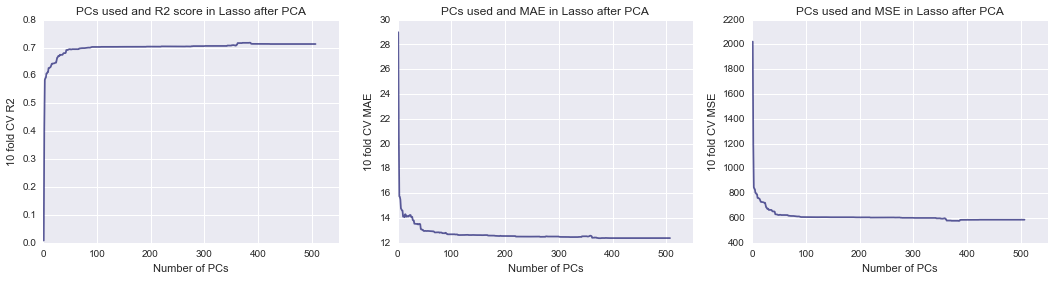

In [106]:
fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(range(1,508), las_cv_r2, color='midnightblue', alpha=.7)
ax2.plot(range(1,508), las_cv_mae, color='midnightblue', alpha=.7)
ax3.plot(range(1,508), las_cv_mse, color='midnightblue', alpha=.7)
ax1.set(xlabel='Number of PCs',
        ylabel='10 fold CV R2',
        title='PCs used and R2 score in Lasso after PCA',
        xlim=[0,550])
ax2.set(xlabel='Number of PCs',
        ylabel='10 fold CV MAE',
        title='PCs used and MAE in Lasso after PCA',
        xlim=[0,550])
ax3.set(xlabel='Number of PCs',
        ylabel='10 fold CV MSE',
        title='PCs used and MSE in Lasso after PCA',
        xlim=[0,550])
plt.show()

The above plots clearly shows that beyond 100 PCs, the improvement in regression metrics with the number of PCs are very minimal. It is interesting to find that although 99% of the variacne is explained by the first 3 PCs, the MSE and MAE continue to drop as more PCs are included in the analysis. It can be seen that MAE never really stop decreasing until we hit a point of around 360 PCs. MSE has a more stable curve and hits the minimum at around 380 PCs. However we should always question how confident we are in the gain in performance especially when the gain is very small. 

After gaining the above insight, it is decided to fit a model and perform a prediction on the test set using the first 100 PCs.

In [107]:
px_train = pca_X_train[:,:100]
px_test = pca_X_test[:,:100]
las = Lasso(max_iter=3000, alpha=0.01)
las_score = cross_val_score(las,px_train,pca_y_train,cv=10)
pca_las_model = las.fit(px_train,pca_y_train)
pca_las_pred = pca_las_model.predict(px_test)
print 'CV scores on train set: ',las_score
print 'Mean CV score on train set: ',np.mean(las_score)
print 'MSE: ',mean_squared_error(pca_y_test,pca_las_pred)
print 'MAE: ',mean_absolute_error(pca_y_test,pca_las_pred)
print 'R2: ', r2_score(pca_y_test,pca_las_pred)


CV scores on train set:  [ 0.67966447  0.64534871  0.75107152  0.60101141  0.71496506  0.65692351
  0.76133744  0.71508126  0.78026166  0.67060349]
Mean CV score on train set:  0.697626852901
MSE:  598.066372553
MAE:  12.429405682
R2:  0.739403016847


As we can see from the results the MSE has drastically reduced from 938 to 598. This represents a reduction of 340 which is  a 36% improvement. MAE has reduced by 0.5. R2 score has increased (despite the number of features has decreased) to 0.73 from 0.59 which is a significant 24% improvement. 

These results have reinforced the findings earlier that by further increasing the number of PCs up to a certain point, it is still able to improve model performance despite the fact that gain in variance explained is minimal.

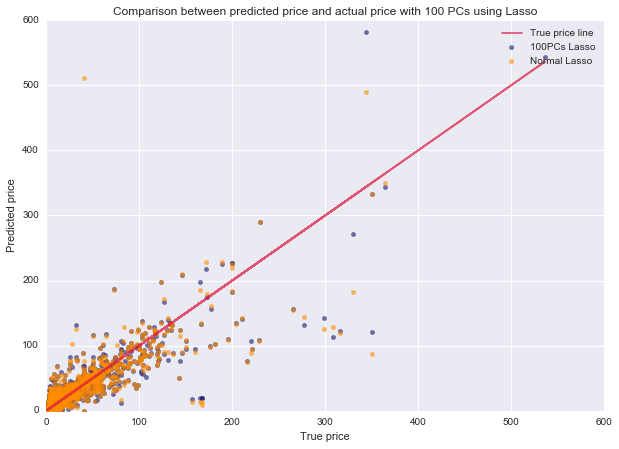

In [114]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(pca_y_test,pca_las_pred, color='midnightblue', alpha=.6,label='100PCs Lasso')
ax1.scatter(y_test, lasso_pred, color='darkorange', alpha=.6, label='Normal Lasso')
ax1.set(xlabel='True price',
        ylabel='Predicted price',
        title='Comparison between predicted price and actual price with 100 PCs using Lasso',
        xlim=[0,600],
        ylim=[0,600])
ax1.plot(y_test,y_test,color='crimson',alpha=.7,label='True price line')
plt.legend()
plt.show()

When we try to compare the vanilla Lasso and 100PCs Lasso it is not very obvious where the improvements are made. We can see that the blue points (100PCs Lasso) might be slightly closer to the 'True price line'. However if we look more carefully we can see that one points that was previously seriously mis-predicted (point at around (45,510)) is now in a much better position. This in fact reflects what we have discovered in the results comparison earlier on. The great reduction in MSE is due to the fact that MSE is a metric that is heavily influenced by outlier. If an outlier is removed the MSE can vary by a large amount. On the ohter hand MAE is less prone to such problem and hence we can only observe a slight improvement in MAE. 

The R2 score observed in this model can be considered reasonable. The interpretation of R2 score is the proportion of variance explained by the model to the total variance. It can be seen that our model is able to explain more than 70% of the variance. This can be considered as reasonable score since pricing of a certain Lego set is a result from various activites where human decisions are invloved. Threfore it is not as rigid as some other problems such as testing for physical phenomenon in the scientific research (which can yield a R2 score of over 90%). 

## Initial classification analysis on desirable Lego sets. 

Apart from trying to predict MSRP for Lego sets, the other aim of the project is to successfully classify Lego sets into categories of being nomal sets or desirable sets. The success criteria is to perform better than the baseline accuracy which is yet to be determined. From the EDA we have concluded that the 'wanted' column will be used as our metric. A threshold value would be set and depending on the counts for each instance in the wanted column, they will be classified as being either desirable or normal. It would be reasonable to start oof with such categorsation.

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc, classification_report, confusion_matrix, precision_score, recall_score, f1_score

A new column which serve as the classification labels is to be created. At this point we would have to define a threshold line to determine which sets are desirable. This threshold can be set at the 80 percentile hence dividing the data into 2 groups with the top 20% being desriable. This sets our baseline accuracy to 80%. This is becuase if we blindly guess that all instances have a label of 0, we will get an 80% accuracy. Therefore a good model should perform better than this accuracy.

In [19]:
np.percentile(lego.wanted, 80)

1091.0

In [20]:
lego_w_dummies['labels'] = lego_w_dummies.wanted.apply(lambda x:0 if x<1091 else 1)
lego_w_dummies['labels'].value_counts()

0    4832
1    1211
Name: labels, dtype: int64

The next step is to create the features and label matrix respectively

In [21]:
X = lego_w_dummies.drop(['wanted','labels'], axis=1)
y = lego_w_dummies['labels']

For the same reason as in the regression analysis, a train-test split is be carried out in order to prevent overfitting. Again this operation divides the data into a training set and a testing set. This allows us to fit the model with the train data and test it with the unseen test data. Again the train data would include the majority of instances in the data set to allow good model fit. Therefore it is decided that a 4:1 train-test split to be used. Since the features and target are different from the regression analysis, the train test split has to be redefined.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

The first model to try is Logistic Regression. Similar to Linear Regression used in predicting MSRP, Logistic Regression is also a linear model. It relates the log of odds being positive (label = 1) to the predicting features. The assumption of the the model is that the log of odds varies linearly with the predicting features. The advantage of this model is that it is easy to understand. Also being a linear model it is relatively simple and quick to fit hence is suitable to be used as the first model. 

In [23]:
clf = LogisticRegression()
model = clf.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.93217535153
ROCAUC:  0.884449369077
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       956
          1       0.86      0.80      0.83       253

avg / total       0.93      0.93      0.93      1209

[[924  32]
 [ 50 203]]


The results above shows that Logistic Regression has a very respectable performance of 93% accuracy. This is complemented with a good ROC score of 0.88. ROC score describes the area under the ROC curve. In the Scikit Learn implementation, the baseline ROC score would be 0.5. That means if you are randomly guessing, the mean ROC score that you would likely to get is very close to 0.5.

Looking at the classification report, it seems that the model is better at classifying labels with 0s than labels with 1s. This is expected because we have much more instances that have a true label of 0. However it should be noted that this train-test split is not stratified. Therefore a model performing well in this case might not perform well in other cases where the data is splitted differently. In order to varify that we have got a stable model, a 10 fold cross validation is carried out with the training data to let us gain more insight.

In [24]:
score = cross_val_score(clf,X_train,y_train,cv=10)
print 'Average accuracy: ',np.mean(score)
print score

Average accuracy:  0.94352692516
[ 0.96280992  0.95661157  0.90909091  0.92975207  0.93801653  0.95041322
  0.93581781  0.97101449  0.95850622  0.92323651]


In [25]:
np.std(score)

0.01856741849456477

The average accuracy is 94.4% with a minimum accuracy of 90.9% and maximum accuracy of 97.1%. The standard deviation is 0.0186 which can be translated to an understanding that 95% of the accuracy is likely to fall between 94.4% +- 3.6%. This is sufficient to prove that our model is relatively stable and should be able to handle unseen data with reasonable performance. However it is still possible to try improving this model.

The first step is to use Grid Search in order to find out the optimum hyper-parameter for Logistic Regression classifier.

In [26]:
params = {'penalty':['l1','l2'], 'C':np.logspace(-2,2,5)}
model = GridSearchCV(clf,params,cv=10).fit(X_train,y_train)
print 'Best parameters: ',model.best_params_
print 'Best accuracy: ',model.best_score_

Best parameters:  {'penalty': 'l1', 'C': 10.0}
Best accuracy:  0.950558543649


In [27]:
model_logreg = model.best_estimator_.fit(X_train,y_train)
pred = model_logreg.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.94540942928
ROCAUC:  0.910256834306
             precision    recall  f1-score   support

          0       0.96      0.97      0.97       956
          1       0.88      0.85      0.87       253

avg / total       0.94      0.95      0.95      1209

[[928  28]
 [ 38 215]]


The above analysis demonstrated that by using Grid Search we sucessfully find a better parameter to fit the model. The penalty is set to be 'l1'. This has a very similar effect comparing with Lasso when regression analysis is performed. L1 regularisation has a penalty term related to the absolute values of the coefficients. Like Lasso it is also possible to set coefficients of certain features to 0 which can be considered as automatic feature selection. In Scikit Learn implementaion the penalty term is denoted by a prameter named 'C'. It is inversely proportional to the regularisation coefficient alpha. This means that as 'C' gets larger, alpha gets smaller i.e. less regularisation is applied. Grid Search returned a 'C' value of 10 which is higher than default. This means that for this problem a lower regularisation seems to be beneficial.

The following section demonstates the use of other classifiers and their default parameters as comparisons. 

In [28]:
knn = KNeighborsClassifier()
model = knn.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.880893300248
ROCAUC:  0.801158069691
             precision    recall  f1-score   support

          0       0.91      0.94      0.93       956
          1       0.74      0.66      0.70       253

avg / total       0.88      0.88      0.88      1209

[[897  59]
 [ 85 168]]


In [29]:
dt = DecisionTreeClassifier()
model = dt.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.928866832093
ROCAUC:  0.892530223097
             precision    recall  f1-score   support

          0       0.96      0.96      0.96       956
          1       0.83      0.83      0.83       253

avg / total       0.93      0.93      0.93      1209

[[913  43]
 [ 43 210]]


In [30]:
rf = RandomForestClassifier()
model = rf.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.94540942928
ROCAUC:  0.894270841947
             precision    recall  f1-score   support

          0       0.95      0.98      0.97       956
          1       0.92      0.81      0.86       253

avg / total       0.94      0.95      0.94      1209

[[939  17]
 [ 49 204]]


In [31]:
ab = AdaBoostClassifier()
model = ab.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.939619520265
ROCAUC:  0.896422842211
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       956
          1       0.88      0.82      0.85       253

avg / total       0.94      0.94      0.94      1209

[[928  28]
 [ 45 208]]


In [32]:
et = ExtraTreesClassifier()
model = et.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.943755169562
ROCAUC:  0.900491177006
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       956
          1       0.90      0.83      0.86       253

avg / total       0.94      0.94      0.94      1209

[[932  24]
 [ 44 209]]


In [33]:
gb = GradientBoostingClassifier()
model = gb.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.947890818859
ROCAUC:  0.908919327898
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       956
          1       0.90      0.84      0.87       253

avg / total       0.95      0.95      0.95      1209

[[933  23]
 [ 40 213]]


In [34]:
sv = SVC()
model = sv.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.795698924731
ROCAUC:  0.535110060033
             precision    recall  f1-score   support

          0       0.80      0.98      0.88       956
          1       0.58      0.09      0.15       253

avg / total       0.76      0.80      0.73      1209

[[940  16]
 [231  22]]


The brief analysis above shows that ensemble methods do have a significant edge in this calssification problem. By look at the performance of the ensebles, it is possible to say that they are on par with the tuned Logistic Regression. Therefore it is decided that Grid Search will be used to further enhance those models.

In [35]:
params = {'n_estimators':[100,1000], 'min_samples_split':[2,5,8]}
model = GridSearchCV(rf,params,cv=10, n_jobs=2).fit(X_train,y_train)
print 'Best parameters: ',model.best_params_
print 'Best accuracy: ',model.best_score_

Best parameters:  {'min_samples_split': 2, 'n_estimators': 100}
Best accuracy:  0.959040132396


In [36]:
optimised_rf = model.best_estimator_.fit(X_train, y_train)
pred = optimised_rf.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.960297766749
ROCAUC:  0.931297236509
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       956
          1       0.93      0.88      0.90       253

avg / total       0.96      0.96      0.96      1209

[[938  18]
 [ 30 223]]


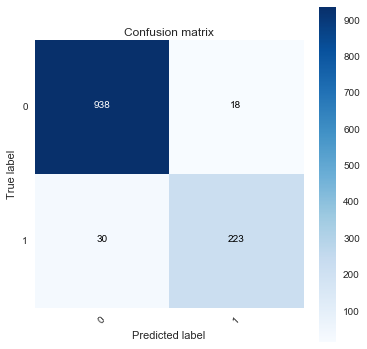

In [37]:
# DIY module saved in a .py file to conveniently call frequently used functions
from ricky_custom import plot_confusion_matrix
plot_confusion_matrix(confusion_matrix(y_test,pred), classes=optimised_rf.classes_)

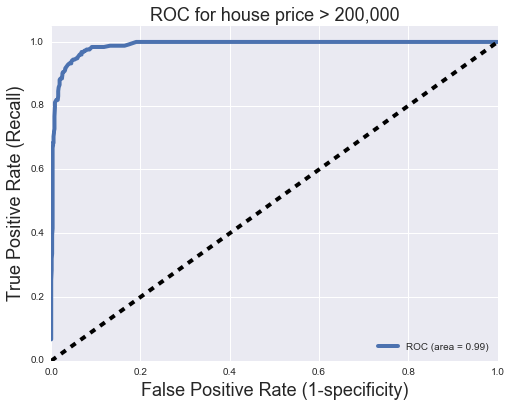

In [39]:
from ricky_custom import plot_roc
plot_roc(y_test,optimised_rf.predict_proba(X_test)[:,1])

From the confusion matrix and ROC curve plot above we can see that the Random Forest model has a very respectable performance. The high ROC and accuracy scores means the prediction gets most of the cases right. By further analysing the confusion matrix we can see that there are more false negatives than false positives. This is demosntrated in the recall score for class 1 in the classification report.

Apart from optimising the good models, it is also interesting to try improving the less capable models. For this problem SVM and kNN are not performing very well comparing to the others. They have a test set score of 80% and 88% respectively. However we know that both algorithm rely heavily on the distances between data points in a feature space. Therefore feature scaling will be applied in other to try obtaining better results for these 2 models.

In [41]:
scaler = StandardScaler()
std_lego = pd.DataFrame(scaler.fit_transform(lego),columns=lego.columns)
std_lego_w_dummies = pd.concat([std_lego,theme,subtheme,packaging,availability,theme_grp],axis=1)
std_X = std_lego_w_dummies.drop(['wanted','labels'], axis=1)
std_X_train, std_X_test, y_train, y_test = train_test_split(std_X,y,test_size=0.2,random_state=42)

In [42]:
knn = KNeighborsClassifier()
model = knn.fit(std_X_train,y_train)
pred = model.predict(std_X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.949545078577
ROCAUC:  0.918684985199
             precision    recall  f1-score   support

          0       0.96      0.97      0.97       956
          1       0.89      0.87      0.88       253

avg / total       0.95      0.95      0.95      1209

[[929  27]
 [ 34 219]]


In [43]:
sv = SVC()
model = sv.fit(std_X_train,y_train)
pred = model.predict(std_X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.907361455749
ROCAUC:  0.833880463724
             precision    recall  f1-score   support

          0       0.93      0.96      0.94       956
          1       0.82      0.71      0.76       253

avg / total       0.90      0.91      0.90      1209

[[918  38]
 [ 74 179]]


After applying the StandardScaler to transform the feature, it is evident that both kNN and SVM have received a large improvement in terms of prediction accuracy and ROC score. The performance of the kNN classifier is now even comparable to the tuned Logistic Regression model. SVM whilst not as good as the others, has improved its accuracy by 10%. This is a significant improvement as it is now performing better than the baseline accuracy.

## Summary

#### Introduction and preliminary data analysis
After the EDA, progress has been made to fit models initially. Preliminary work was carried out to investigate the relationship between numerical features in the dataframe. it is found out that in general the features are either positively correlated or not very correlated. There are some features that correlate strongly. They are number of pieces and MSRP, number 'wanted' and number 'owned' and number of pieces and number 'wanted'. 

There are quite a few features that are categorical so dummy variables were creatd to accomodate this fact. This resulted in a matrix with over 500 columns which is quite sparse. However considering that we have more than 6000 instances we can still consider this ratio acceptable.

#### Regression
Initial regression analysis was carried out to try predicting the MSRP from other features. The dataset is divided into a training set and testing set in order to test the model with unseen data. Cross validation was also applied through out the investigation to further ensure that the chance of over fitting is reduced to a minmum. In the first attempt a linear regression model is fitted directly with the feature data. The testing result produced in the test set is very unreasonable with unrealistic MSRP such as below 0 and in the millions. it is suggested that the model could be seriously overfitting and therefore Lasso and Ridge were performed. These models produce significantly better results with MSE and MAE reduced to around 800-900 and 12.5-14 respectively. 

Further investigation with PCA was carried out. It is found out that only 3PCs (out of the total 508) can explain more than 99% of the variance. However it is found out that the model performance max out when aroudn 100 PCs are used. PCA improves the overall performance of the Lasso model slightly with a 0.5 reduction of MAE. However it has successfully removed an outlier which significantly improves MSE.

#### Classification
The second aim of the project is to successfully classify which Lego sets are desirable. Refering back to the EDA it is decided that as initial analysis, the definition of how desirable a Lego set is by its number of 'wanted' votes. It is set that the top 20% of the data is considered desirable while others are considered normal. This 20% threshold is set casually without much supporting reason. However we are in the initial model fitting stage and this would suffice.  A Logistic Regression model is tried initially. This is because being a linear model Logistic Regressin is relatively simple and easy to understand. It is also not computationally intensive which should give us a good understanding of the situation. The inital result returned a promising 93% for the testing set and 94% in cross validation of the training set. This is surprisingly high and this could be due to the fact that regularisation is applied as standard. Through Grid Search a better parameter is obtained which further improves accuracy by 1%. 

Due to the promising result it is decided that other models can be fitted and see how they perform. It is found out that the ensemble models (e.g. Random Forest and Adaboos) performs very well out of the box which can rival tuned Logistic Regression. With some parameters tuning, a test accuracy of 96% can be obtained by Random Forest. 

However some models do not perform well in standard form namely SVM and kNN. The common feature of these models is that the distance between data points drastically affects classification performance. Therefore feature scaling was applied which significantly improves their results (88% to 94% and 80% to 90%) respectively.


#### Next steps

From the above report we can consider that the initial models were quite successful. However we should also note that these successes can be highly correlated with the data structure. If we recall the correlations that we discovered in the initial analysis, we know that number of piece and MSRP is highly correlated. The situation for the classification problem is also very similar. Therefore it is not too surprising that a good model can be built. To further advance our analysis the following paths could be take:

- Redefine how desirable a Lego set is by choosing other metrics as described in EDA and repeat the classification analysis

- The predictions carried out here in the initial phase might not be the most useful ones. This is because we have included many features that are available only after the set is released. For example number of reviews and 'wanted'/'owned' counts. This does not really help collectors to determine a set's value early on. Therfore to mitigate this problem, we might want to exclude the latent variables and perform the predictions solely by the other features which do not include much human influence (e.g. number of piece, themes).

- There is another data set that contains information relating Lego sets with their parts. This is a large data frame and would introduce challenges in terms of high dimensionality. An analysis could be carried out to try figuring out which Lego pieces drive the price or the desirable-ness of a Lego set.

- Futher enquire the API of Bricklink to obtain current prices for Lego sets. The API contains prices (mean,max,min) for most Lego sets (the ones that are actively traded) in the past 6 months. An investigation can be carried out regarding the factors that drive appreciation/depreciation of Lego sets. This could be valueable to Lego collectors/investors. 

- Since Capstone is a showcase of capability, it is possible for this project to extend to some more advanced techniques such as image recognition using deep neural networks. If the image recognition is successful, a recommendation system can be created to provide build ideas to users when given a picture of various Lego pieces. This technology challenging but it would provide tremendous values because a similar idea can be applied in many other situations. It would also be a great demonstration in the final presentation as this can be made into an interactive application.


The paths mentioned above are the more obvious suggesstions and the development of the project should not be limited to those options. However a progressing plan should be formed before the end of week 10 in order to give a clear direction of advancement. 